<a href="https://colab.research.google.com/github/pranavrao87/Classification-Models/blob/main/pneumonia_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pneumonia Binary Classification using a Kaggle Dataset and TinyVGG Architecture

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [13]:
# Upload Kaggle API Token
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prao87","key":"1612eff0c0c1713e556e8cb753f26996"}'}

In [14]:
import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [15]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:12<00:00, 244MB/s]
100% 2.29G/2.29G [00:12<00:00, 192MB/s]


In [16]:
# Extract and unzip file
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip")
zip_ref.extractall()
zip_ref.close()

In [17]:
# Walking through the dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'chest_xray'.
There are 1 directories and 1 images in 'chest_xray/__MACOSX'.
There are 3 directories and 3 images in 'chest_xray/__MACOSX/chest_xray'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/__MACOSX/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/__MACOSX/chest_xray/test/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/__MACOSX/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/__MACOSX/chest_xray/val/PNEUMONIA'.
There are 0 directories and 9 images in 'chest_xray/__MACOSX/chest_xray/val/NORMAL'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/train'.
There are 0 directories and 3876 images in 'chest_xray/__MACOSX/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1342 images in 'chest_xray/__MACOSX/chest_xray/train/NORMAL'.
There are 3 directories and 1 images 

In [18]:
import shutil

shutil.rmtree('/content/chest_xray/__MACOSX', ignore_errors=True)
shutil.rmtree('/content/chest_xray/chest_xray', ignore_errors=True)

In [19]:
# Walking through the dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.


## Visualizing Data

In [20]:
from re import A
# Visualize the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory
  target_folder = target_dir + "/" + target_class

  # Get rand image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items from here
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show shape of image

  return img

In [21]:
# Setting up the train and test directories
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"

In [22]:
# Getting class names (subdirectories)
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob('*')))
print(class_names)

['NORMAL' 'PNEUMONIA']


['NORMAL2-IM-1150-0001.jpeg']
Image shape: (1310, 1696)


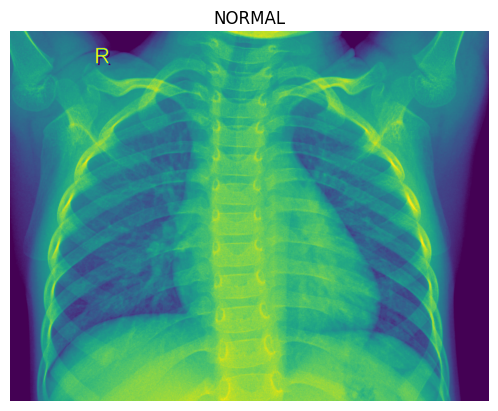

In [23]:
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## Baseline model (limited data pre-processing)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam


In [25]:
# Creating the data loaders or data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')


val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Running the model w/ test_data as validation b/c val data set is rly small and not good

In [26]:
model_1 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_1.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/5
163/163 [==============================] - 63s 314ms/step - loss: 0.2504 - accuracy: 0.8972 - val_loss: 0.6850 - val_accuracy: 0.7420
Epoch 2/5
163/163 [==============================] - 52s 321ms/step - loss: 0.1119 - accuracy: 0.9597 - val_loss: 0.9350 - val_accuracy: 0.7500
Epoch 3/5
163/163 [==============================] - 53s 326ms/step - loss: 0.0827 - accuracy: 0.9688 - val_loss: 0.9732 - val_accuracy: 0.7276
Epoch 4/5
163/163 [==============================] - 58s 358ms/step - loss: 0.0733 - accuracy: 0.9735 - val_loss: 1.1717 - val_accuracy: 0.7548
Epoch 5/5
163/163 [==============================] - 52s 320ms/step - loss: 0.0579 - accuracy: 0.9768 - val_loss: 1.0745 - val_accuracy: 0.7500


In [27]:
model_1.evaluate(test_data)

20/20 [==============================] - 5s 224ms/step - loss: 1.0745 - accuracy: 0.7500


[1.0744835138320923, 0.75]

In [28]:
# Plot validation and training curves
def plot_loss_curves(history):
  """
  Returns seperte loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs were ran

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

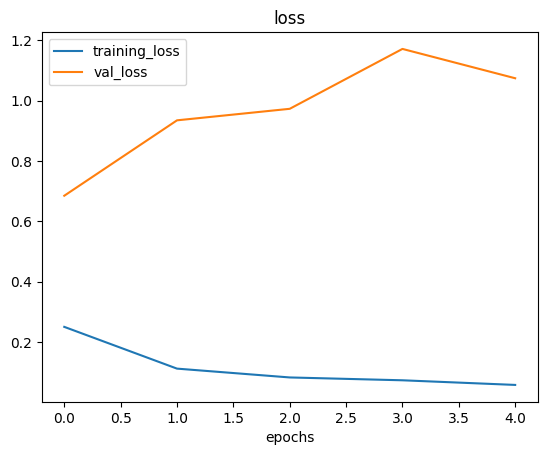

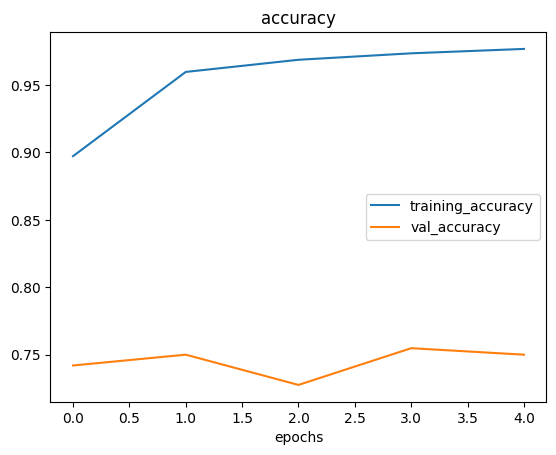

In [29]:
plot_loss_curves(history_1)

Very high training accuracy, but very low test accuracy therefore the model is overfitting

## Data pre-processing

First experiment : Reconfigure the data split

In [30]:
# Walking through the dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 8 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 8 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3875 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1341 images in 'chest_xray/train/NORMAL'.


In [31]:
390 + 8 + 3875

4273

In [32]:
1341 + 234 + 8

1583

*   Training: 80%
*   Test: 10%
*   Val: 10%

### Pneumonia images

In [33]:
0.8 * 4273

3418.4

In [34]:
0.1 * 4273

427.3

In [35]:
3875-3418
# 457 extra in training

457

In [36]:
427 - 390

37

In [37]:
457-37

420

roughly 37 images moved from train to test for pneumonia

rest 420 images get moved from training to validation set for penumonia

### Normal images

In [38]:
0.8 * 1583

1266.4

In [39]:
0.1 * 1583

158.3

In [40]:
1341 - 1266
# 75 extra images in training

75

In [41]:
234 - 158
# 76 extra images in testing

76

In [42]:
75+76+8

159

75 images from train to val for normal


76 images from test to val for normal

### Sort the images

Evening the ditribution for the training, testing, and val sets

In [43]:
# Moving files to extra folder to even out the image datasets
import random
def move_random_images(source, dest, num_files):
  files = os.listdir(source)
  for file_name in random.sample(files, num_files):
    shutil.move(os.path.join(source, file_name), dest)

In [44]:
# Pneumonia
move_random_images(source="chest_xray/train/PNEUMONIA", dest="chest_xray/test/PNEUMONIA", num_files=37)
move_random_images(source="chest_xray/train/PNEUMONIA", dest="chest_xray/val/PNEUMONIA", num_files=420)

# Normal
move_random_images("chest_xray/train/NORMAL", "chest_xray/val/NORMAL", 75)
move_random_images("chest_xray/test/NORMAL", "chest_xray/val/NORMAL", 76)


In [45]:
# Walk through re-organize dataset
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 427 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 158 images in 'chest_xray/test/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/val'.
There are 0 directories and 428 images in 'chest_xray/val/PNEUMONIA'.
There are 0 directories and 159 images in 'chest_xray/val/NORMAL'.
There are 2 directories and 0 images in 'chest_xray/train'.
There are 0 directories and 3418 images in 'chest_xray/train/PNEUMONIA'.
There are 0 directories and 1266 images in 'chest_xray/train/NORMAL'.


## Model 2

redistributed the images amongs the training, testing, and validation sets. (80/10/10 split)

In [46]:
# Creating the data loaders or data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')


val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='binary')

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


In [47]:
model_2 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
147/147 [==============================] - 52s 328ms/step - loss: 0.2589 - accuracy: 0.8928 - val_loss: 0.4906 - val_accuracy: 0.8671
Epoch 2/5
147/147 [==============================] - 46s 313ms/step - loss: 0.1122 - accuracy: 0.9579 - val_loss: 0.3504 - val_accuracy: 0.8756
Epoch 3/5
147/147 [==============================] - 47s 319ms/step - loss: 0.0842 - accuracy: 0.9675 - val_loss: 0.6723 - val_accuracy: 0.8535
Epoch 4/5
147/147 [==============================] - 47s 317ms/step - loss: 0.0757 - accuracy: 0.9735 - val_loss: 0.3493 - val_accuracy: 0.8910
Epoch 5/5
147/147 [==============================] - 48s 328ms/step - loss: 0.0768 - accuracy: 0.9727 - val_loss: 0.4643 - val_accuracy: 0.8910


In [48]:
model_2.evaluate(test_data)

19/19 [==============================] - 4s 220ms/step - loss: 0.7214 - accuracy: 0.7966


[0.7214322090148926, 0.7965812087059021]

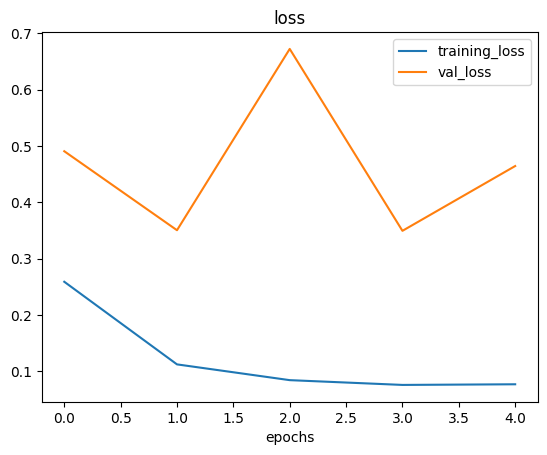

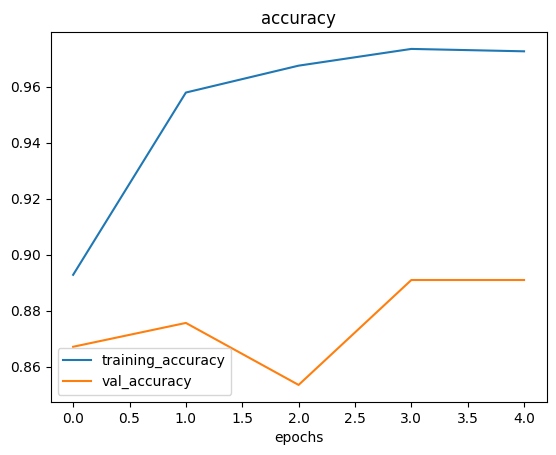

In [49]:
plot_loss_curves(history_2)

## Data Augmentation

In [50]:
# Re-instantiate w/ augmented training data
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                          rotation_range=0.2,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True)

train_data_aug = train_datagen_augmented.flow_from_directory(train_dir,
                                                             target_size=(224, 224),
                                                             batch_size=32,
                                                             class_mode="binary")

Found 4684 images belonging to 2 classes.


In [51]:
model_3 = tf.keras.models.clone_model(model_2)

model_3.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_3 = model_3.fit(train_data_aug,
                        epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
147/147 [==============================] - 98s 649ms/step - loss: 0.4141 - accuracy: 0.8149 - val_loss: 0.3705 - val_accuracy: 0.8433
Epoch 2/5
147/147 [==============================] - 97s 660ms/step - loss: 0.3318 - accuracy: 0.8612 - val_loss: 0.3480 - val_accuracy: 0.8552
Epoch 3/5
147/147 [==============================] - 95s 643ms/step - loss: 0.2808 - accuracy: 0.8836 - val_loss: 0.4537 - val_accuracy: 0.8296
Epoch 4/5
147/147 [==============================] - 95s 647ms/step - loss: 0.2684 - accuracy: 0.8875 - val_loss: 0.6027 - val_accuracy: 0.7853
Epoch 5/5
147/147 [==============================] - 95s 645ms/step - loss: 0.2561 - accuracy: 0.8941 - val_loss: 0.4483 - val_accuracy: 0.8416


In [52]:
model_3.evaluate(test_data)

19/19 [==============================] - 4s 202ms/step - loss: 0.3685 - accuracy: 0.8650


[0.3685457110404968, 0.8649572730064392]

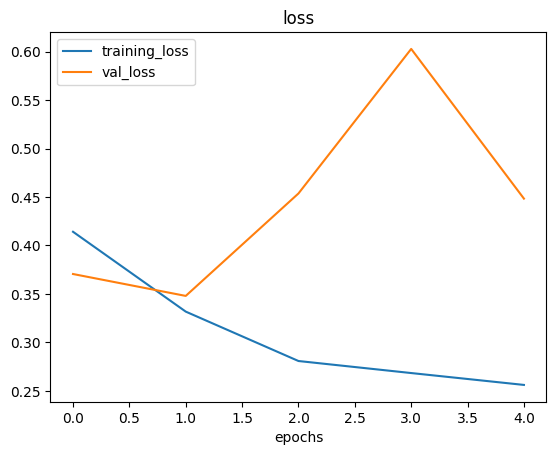

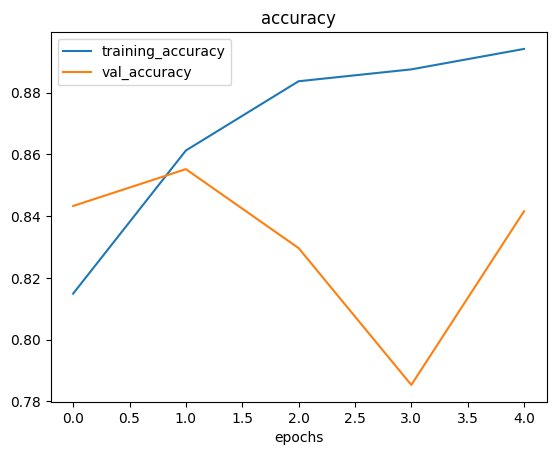

In [53]:
plot_loss_curves(history_3)

In [54]:
model_4 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_4 = model_4.fit(train_data_aug,
                        epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
147/147 [==============================] - 97s 639ms/step - loss: 0.4552 - accuracy: 0.7825 - val_loss: 0.3986 - val_accuracy: 0.8433
Epoch 2/5
147/147 [==============================] - 94s 638ms/step - loss: 0.3024 - accuracy: 0.8678 - val_loss: 0.3751 - val_accuracy: 0.8484
Epoch 3/5
147/147 [==============================] - 99s 677ms/step - loss: 0.2820 - accuracy: 0.8781 - val_loss: 0.3583 - val_accuracy: 0.8637
Epoch 4/5
147/147 [==============================] - 93s 629ms/step - loss: 0.2869 - accuracy: 0.8753 - val_loss: 0.3352 - val_accuracy: 0.8722
Epoch 5/5
147/147 [==============================] - 93s 635ms/step - loss: 0.2707 - accuracy: 0.8849 - val_loss: 0.3454 - val_accuracy: 0.8518


In [55]:
model_4.evaluate(test_data)

19/19 [==============================] - 4s 215ms/step - loss: 0.3568 - accuracy: 0.8308


[0.3568245470523834, 0.8307692408561707]

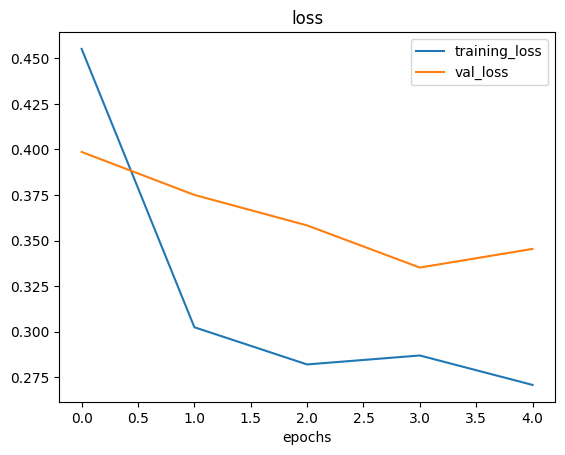

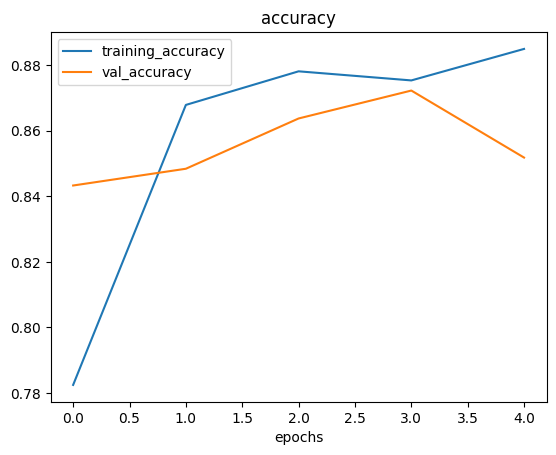

In [56]:
plot_loss_curves(history_4)

## Longer training - (didn't result in much better trianing performance)

In [ ]:
model_5 = tf.keras.models.clone_model(model_2)

model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

history_5 = model_5.fit(train_data_aug,
            epochs=10,
            steps_per_epoch=len(train_data_aug),
            validation_data=val_data,
            validation_steps=len(val_data))

In [ ]:
model_5.evaluate(test_data)

In [ ]:
plot_loss_curves(history_5)

## Trying transfer Learning